[1] - Malha fechada com PID ou [2] - Malha aberta: 
Entre com a malha de controle a ser simulada: 1
Entre com a razão entre constante de tempo de malha fechada e malha aberta - r = tau_mf/tau_ma: 8
_____Eigenvalue______ Damping___ Frequency_
    0.8814   +0.3347j     0.1602      7.352
    0.8814   -0.3347j     0.1602      7.352
SIMULANDO MALHA DE CONTROLE
O valor de ISE calculado para a malha de controle é: 86.5525
O valor de IAE calculado para a malha de controle é: 111.3289
O valor de ISU calculado para a malha de controle é: 4567.5581
O valor de TVC calculado para a malha de controle é: 7.8737


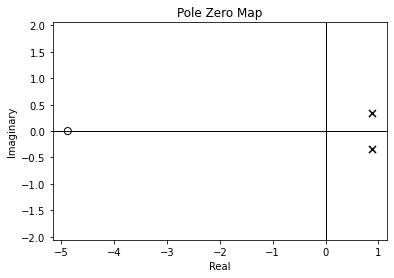

In [1]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from control.matlab import *

print('[1] - Malha fechada com PID ou [2] - Malha aberta: ') # Opções de malha de controle
n = int(input('Entre com a malha de controle a ser simulada: ')) # Seleção da malha de controle

if n == 1:
    r = float(input('Entre com a razão entre constante de tempo de malha fechada e malha aberta - r = tau_mf/tau_ma: '))
elif n == 2:
    r = 1

# Configuração padrão do circuito eletrônico (modelo estocástico)
Az = [1.0, -1.7628271024278894252290683652973, 0.8888827902564973015842042514123] # Polinômio A(z^-1)
Bz = [0.021018021110895027114828792491608, 0.10254201349683352006980641135669] # Polinômio B(z^-1)
Cz = [1.0, -0.015193361616161639784938763853006, -0.0046240196648598139508856696977546] # Polinômio C(z^-1)
Ts = 0.05; d = int(1.0); umax = 5.0; umin = -5.0; # Período de amostragem, delay, limites de saturação do sinal de controle

# Transformar polinômios para numpy array
Az = np.array(Az)
Bz = np.array(Bz)
Cz = np.array(Cz)

# Coeficientes do modelo
a1 = Az[1]; a2 = Az[2]
b0 = Bz[0]; b1 = Bz[1]
c1 = Cz[1]; c2 = Cz[2]

# Ordem dos polinômios A(z^-1), B(z^-1) e C(z^-1)
na = len(Az)-1; nb = len(Bz); nc = len(Cz)-1;

# Extrair informações úteis do sistema a ser controlado
Gz = tf(Bz, Az, Ts) # Função de Transferência discreta
pole(Gz) # Polos do sistema
zero(Gz) # Zeros do sistema
pzmap(Gz) # Plota o mapa de polos e zeros do sitema
wn, csi, poles = damp(Gz) # Frequência natural, coeficiente de amortecimento e polos

# Projeto do controlador PID
kp = dcgain(Gz) # Ganho estático da planta
wn = wn[0] # Frequência natural não amortecida do sistema (rad/s)
csi = csi[0] # Coeficiente de amortecimento considerado
tau_ma = 1/wn # Constante de tempo de malha aberta
tau_mf = r*tau_ma # Constante de tempo de malha fechada
zd = np.exp(-Ts/tau_mf) # Polo real discreto, quanto mais próximo de 1, mais conservativa será a lei de controle

# Parâmetros do PID digital calculados via cancelamento dinâmico de polos
s0 = (1-zd)/(b0+b1); s1 = a1*s0; s2 = a2*s0
t0 = s0; t1 = s1; t2 = s2

# Polinômios do controlador
Sz = [s0, s1, s2]; Tz = [t0, t1, t2]; Rz = [1, -1] # Polinômio S(z^-1), T(z^-1) e R(z^-1)

# Ordem dos polinômios R(z^-1), S(z^-1) e T(z^-1)
nr = len(Rz)-1; ns = len(Sz); nt = len(Tz);

# Malha de controle simulada
print('SIMULANDO MALHA DE CONTROLE')

# Sinal de referência
yr1 = np.zeros([1, 20], float)
yr2 = np.ones([1, 280], float)
yr3 = 3*np.ones([1, 300], float)
yr4 = 2*np.ones([1, 300], float)
yr5 = np.ones([1, 300], float)
yr = np.concatenate((yr1, yr2, yr3, yr4, yr5), axis = 1)
_, nit = yr.shape; nit = int(nit) # Número de iterações

# Perturbação na entrada da planta
v1 = np.zeros([1, 20], float)
v2 = np.zeros([1, 280], float)
v3 = np.zeros([1, 300], float)
v4 = np.zeros([1, 300], float)
v5 = np.zeros([1, 300], float)
v = np.concatenate((v1, v2, v3, v4, v5), axis = 1)

# Inicializar vetores
uv = np.zeros([1, nit], float) # Inicializar vetor de sinal interno (u+v)
yv = np.zeros([1, nit], float) # Inicializar vetor de sinal interno (y+xi)
y = np.zeros([1, nit], float) # Inicializar vetor de sinal de saída
u = np.zeros([1, nit], float) # Inicializar vetor de sinal de controle
du = np.zeros([1, nit], float) # Inicializar vetor de incremento de controle
e = np.zeros([1, nit], float) # Inicializar vetor de sinal de erro

# Inicializar o vetor de tempo
t = np.arange(0,nit*Ts,Ts); t = np.array(t, ndmin=2)

# Inicializar o vetor de ruído de saída
variance = 0*1e-3; # Variância
xi = np.random.normal(0.0, np.sqrt(variance), size = (1, nit)) # xi = np.random.normal(média, desvio padrão, número de amostras)

# Condições iniciais de simulação
for k in range(na+int(d)):
    y[0, k] = 0
    u[0, k] = 0
    e[0, k] = 0
    du[0, k] = 0 

# Malha de controle
for k in range(na+int(d), nit):
    y[0, k] = np.flipud(-Az[1:3]) @ y[0, k-na:k].T +np.flipud(Bz[0:2]) @ u[0, k-na-d+1:k-d+1].T # Sinal de saída
    yv[0, k] = y[0, k] +xi[0, k] +v[0, k] # Sinal de saída medido
    e[0, k] = yr[0, k] -yv[0, k] # Sinal de erro
    
    if n == 1: # Malha fechada
        du[0, k] = np.flipud(Tz[0:3]) @ yr[0, k-nt:k].T -np.flipud(Sz[0:3]) @ yv[0, k-nt:k].T # Incremento de controle
        u[0, k] = u[0, k-1] +du[0, k] # Sinal de controle
    elif n == 2: # Malha aberta
        u[0, k] = yr[0, k] # Sinal de controle
        du[0, k] = u[0, k] -u[0, k-1] # Incremento de controle
    if u[0, k] >= umax: #Saturação da lei de controle
        u[0, k] = umax;
    elif u[0, k] <= umin:
        u[0, k] = umin
        
# Índices de desempenho
ISE = np.sum(e @ e.T); # Integral Square Error
IAE = np.sum(np.absolute(e)); # Integral Absolute Error
ISU = np.sum(u @ u.T); # Integral Square of Control
TVC =  np.sum(np.absolute(du)); # Total Variation of Control

# Apresenta os valores calculados ao usuário
print('O valor de ISE calculado para a malha de controle é: {:.4f}'.format(ISE))
print('O valor de IAE calculado para a malha de controle é: {:.4f}'.format(IAE))
print('O valor de ISU calculado para a malha de controle é: {:.4f}'.format(ISU))
print('O valor de TVC calculado para a malha de controle é: {:.4f}'.format(TVC))

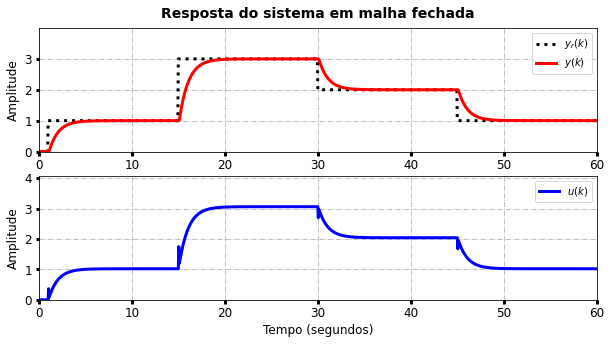

In [2]:
# Gerar gráfico e suas configurações

plt.rc(
    'axes',
    labelweight = 'normal',
    labelsize = 'large',
    titleweight = 'bold',
    titlesize = 14,
    titlepad = 10,
    labelcolor = 'k',
)

if n == 1: # Título para figura caso seja malha fechada
    titulo = 'Resposta do sistema em malha fechada'
elif n == 2: # Título para figura caso seja malha aberta
    titulo = 'Resposta em malha aberta'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 5))
ax1.plot(t.T,yr.T,':k',t.T,yv.T,'r', linewidth = 3)
ax1.axis([0, 60, 0, np.max(yv)+1])
ax1.legend(['$y_r(k)$', '$y(k)$'])
ax1.set(ylabel = 'Amplitude', title = 'Resposta do sistema em malha fechada')
ax1.grid(True, linestyle = '-.')
ax1.tick_params(labelcolor = 'k', labelsize = 'large', width = 3)

ax2.plot(t.T,u.T,'b', linewidth = 3)
plt.axis([0, 60, 0, np.max(u)+1])
ax2.legend(['$u(k)$'])
ax2.set(ylabel = 'Amplitude', xlabel = 'Tempo (segundos)')
ax2.grid(True, linestyle = '-.')
ax2.tick_params(labelcolor = 'k', labelsize = 'large', width = 3)

fig.savefig('PID_Control.png', dpi = 300)

In [3]:
dados = {'yr': list(yr.T), 'u': list(u.T), 'y': list(yv.T), 't': list(t.T)} # Salvar os sinais de interesse
pid_df = pd.DataFrame(data = dados) # Criar o dataframe
pid_df.to_excel('PID Dados.xlsx', index = False) # Salvar o dataframe em formato de arquivo Excel no computador
# pid_df.to_csv('PID Dados.csv', index = False) # Salvar o dataframe em formato de arquivo CSV no computador

In [15]:
pid_df = pd.read_excel('PID Dados.xlsx') # Carregar os dados contidos na tabela do Excel
display(pid_df.tail(10)) # Apresentar ao usuário os 10 últimos valores de cada sinal coletado

,yr,u,y,t
1190,[1.],[1.02019836],[1.00000048],[59.5]
1191,[1.],[1.02019833],[1.00000045],[59.55]
1192,[1.],[1.02019831],[1.00000043],[59.6]
1193,[1.],[1.02019829],[1.00000041],[59.65]
1194,[1.],[1.02019827],[1.00000039],[59.7]
1195,[1.],[1.02019825],[1.00000037],[59.75]
1196,[1.],[1.02019824],[1.00000035],[59.8]
1197,[1.],[1.02019822],[1.00000034],[59.85]
1198,[1.],[1.0201982],[1.00000032],[59.9]
1199,[1.],[1.02019819],[1.0000003],[59.95]
